In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import moscot
from moscot.problems.time import TemporalProblem
import seaborn as sns
from sklearn.preprocessing import StandardScaler

/Users/dominik.klein/opt/anaconda3/envs/moscot_env/lib/python3.8/site-packages/docrep/decorators.py:43: SyntaxWarning: 'plot_time_points' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [3]:
adata = sc.read_h5ad("/Users/dominik.klein/data/pancreas_multiome_2022.h5ad")

In [4]:
adata.obs['time'] = adata.obs.apply(lambda x: 0 if x["sample"]=="E14.5" else 1, axis=1)

In [5]:
adata

AnnData object with n_obs × n_vars = 16953 × 14663
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'total_counts_rank', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'log_nCount_ATAC', 'log_nFeature_ATAC', 'scrublet_scores', 'scrublet_doublets', 'scrublet_doublets_cat', 'dd_doublets', 'dd_scores', 'dd_log_p_values', 'dd_voting_average', 'dd_-log_p_values', 'dd_doublets_cat', 'pANN', 'DF_classifications_1', 'DF_classifications_2', 'pANN_SCT', 'DF_SCT_classifications_1', 'DF_SCT_classifications_2', 'df_doublets', 'scDblFinder.class', 'doublet_calls', 'final_doublets', 'final_doublets_cat', 'batch', 'size_factors', 'mt_fra

In [60]:
adata.obsm["X_pca_log"] = sc.pp.pca(adata.layers["sct_logcounts"])

/Users/dominik.klein/opt/anaconda3/envs/moscot_env/lib/python3.8/site-packages/docrep/decorators.py:43: SyntaxWarning: 'plot_time_points' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/Users/dominik.klein/opt/anaconda3/envs/moscot_env/lib/python3.8/site-packages/docrep/decorators.py:43: SyntaxWarning: 'BaseCompoundProblem_pull.raises' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


# PCA on GEX space

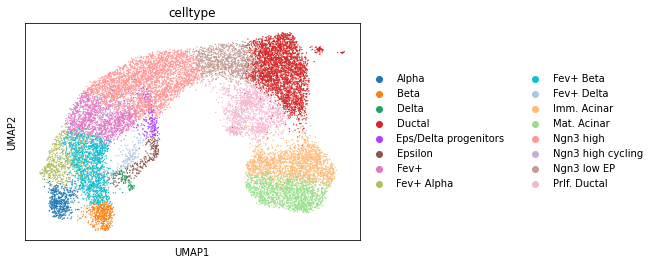

In [9]:
sc.pl.umap(adata, color="celltype")

In [65]:
tp0 = TemporalProblem(adata)
#tp0.score_genes_for_marginals(gene_set_proliferation="mouse", gene_set_apoptosis="mouse")
tp0 = tp0.prepare("time", xy = {"attr": "obsm", "key":"X_pca_log"})

In [66]:
tp0 = tp0.solve(epsilon=1e-2, scale_cost="mean", max_iterations=1e5)

In [67]:
ct_desc = tp0.cell_transition(early_annotation="celltype", late_annotation="celltype", start=0, end=1, forward=True)

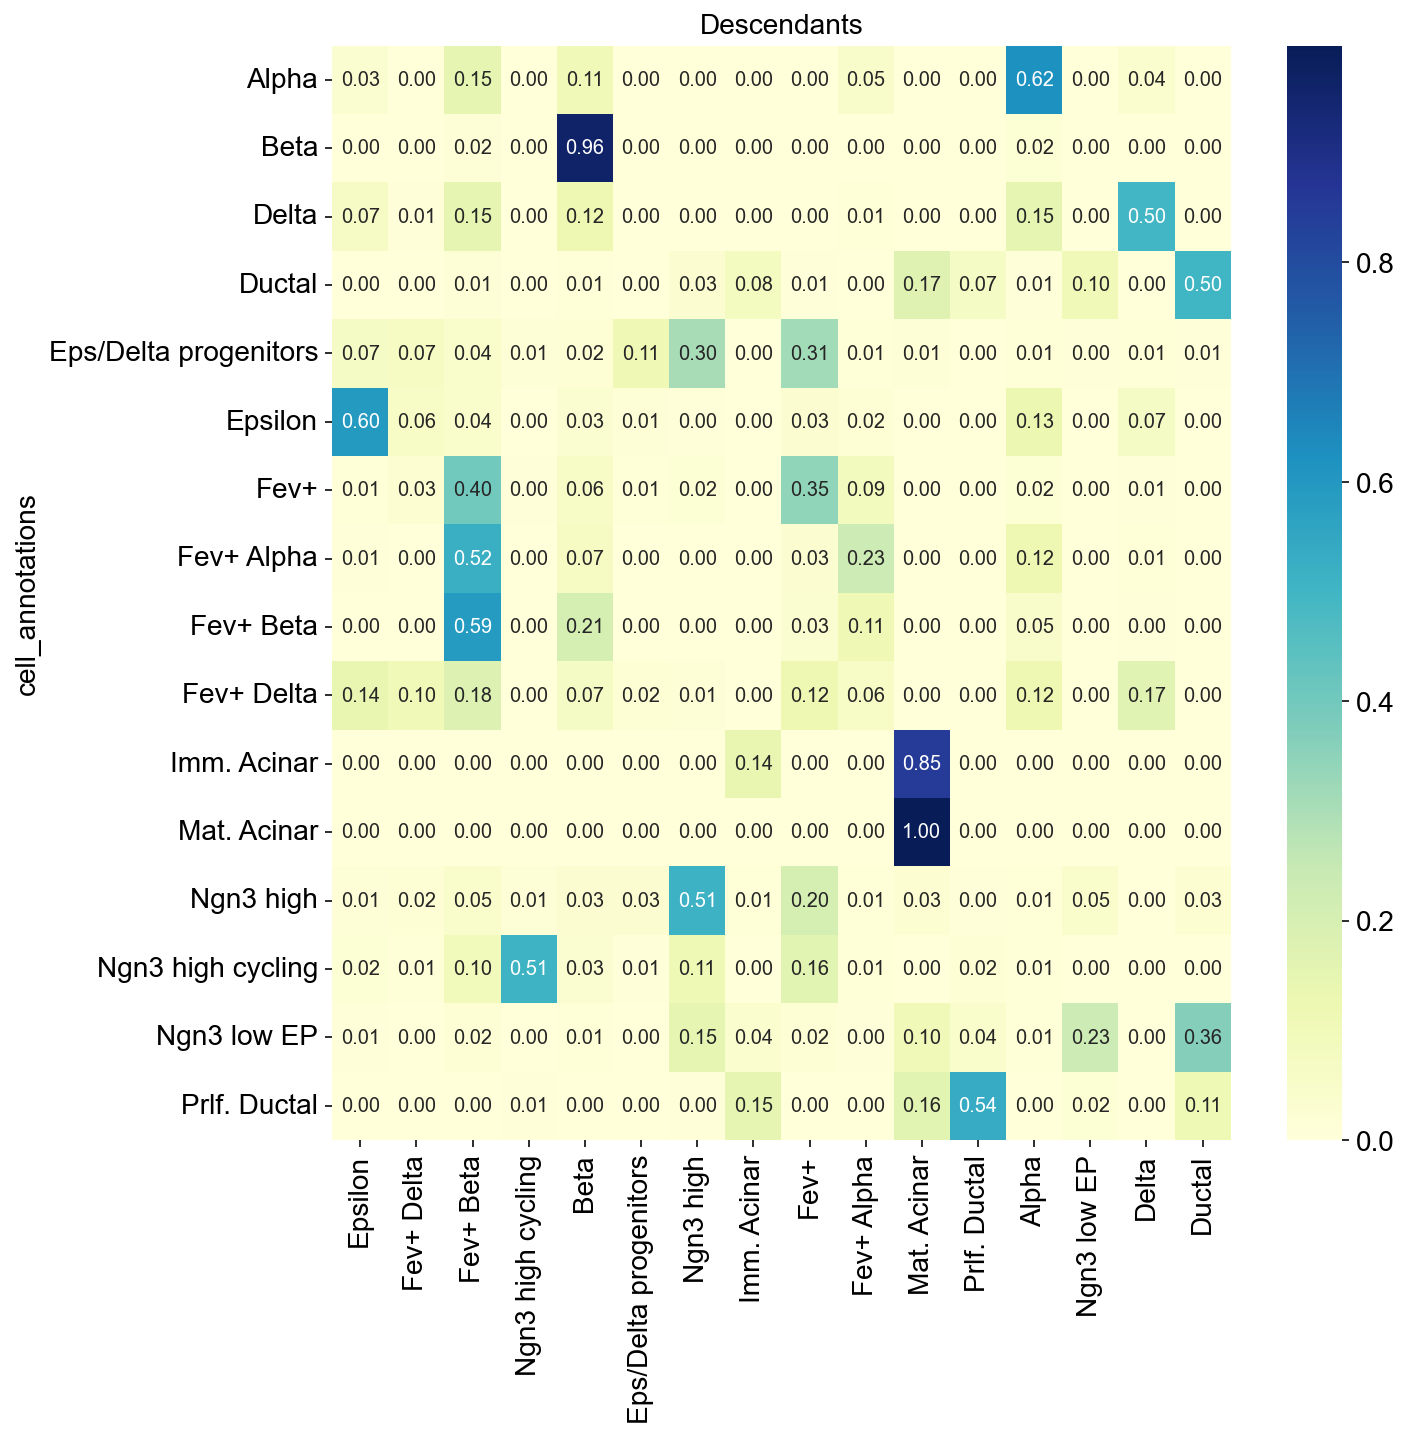

In [68]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(ct_desc, annot=True, cmap="YlGnBu", ax=ax, fmt=".2f", annot_kws={"fontsize": 10})
plt.title("Descendants")
plt.show()

In [41]:
import moscot.pl as msp

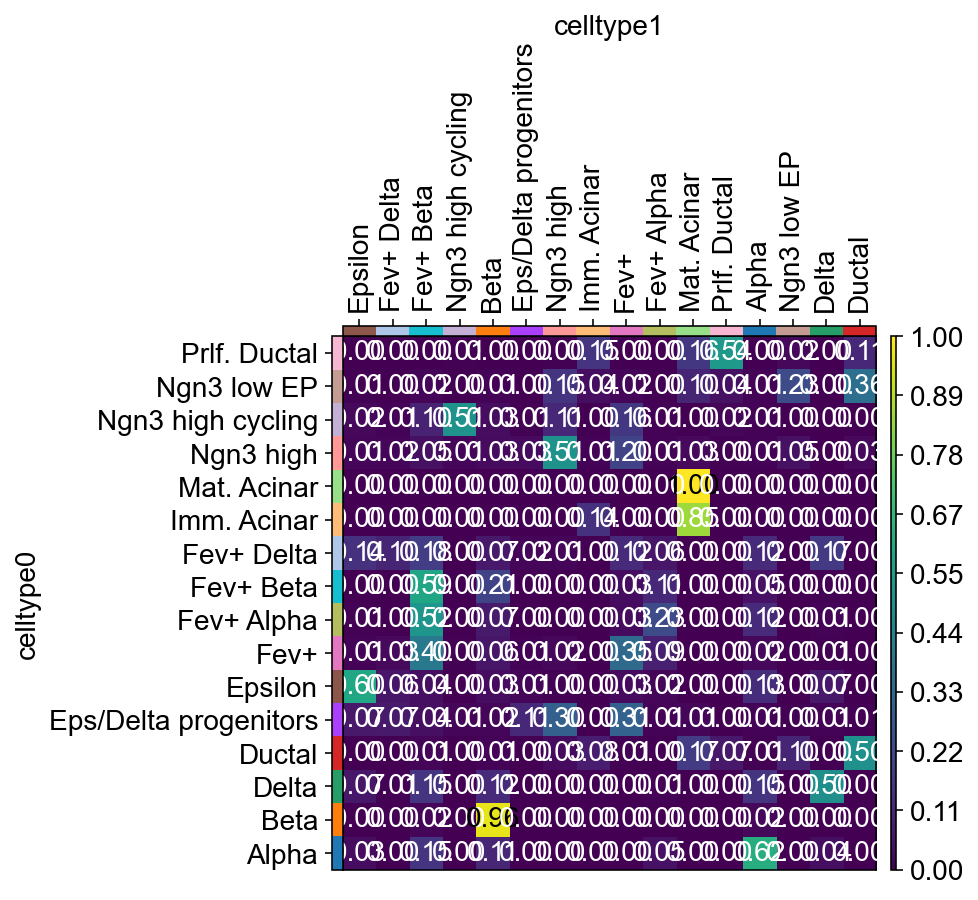

In [42]:
fig = msp.cell_transition(tp0)

In [43]:
p = tp0.push(0,1)

In [44]:
adata.uns["moscot_results"]["push"]

{'push': {'temporal_key': 'time'}}

In [56]:
tp0.push(0,1, data="celltype", subset="Imm. Acinar", key_added='test_push2')

{0: array([[0.        ],
        [0.        ],
        [0.00068681],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]),
 1: DeviceArray([[4.1756214e-13],
              [3.9007677e-08],
              [0.0000000e+00],
              ...,
              [6.0384968e-07],
              [2.5674897e-05],
              [1.0859454e-11]], dtype=float32)}

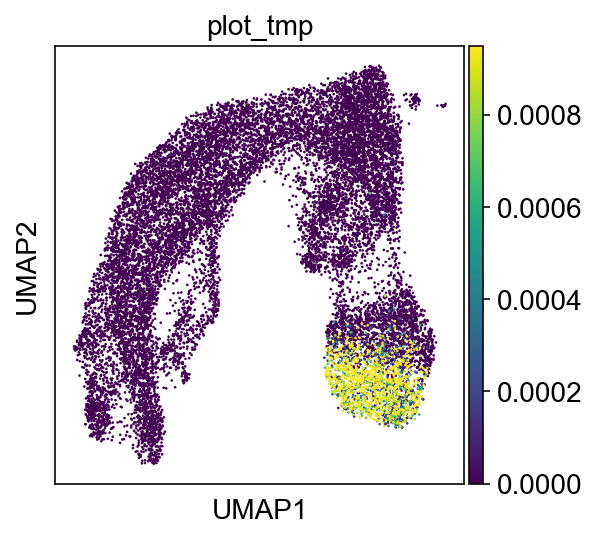

In [58]:
msp.push(tp0, key_stored="test_push2", plot_time_points=[1])

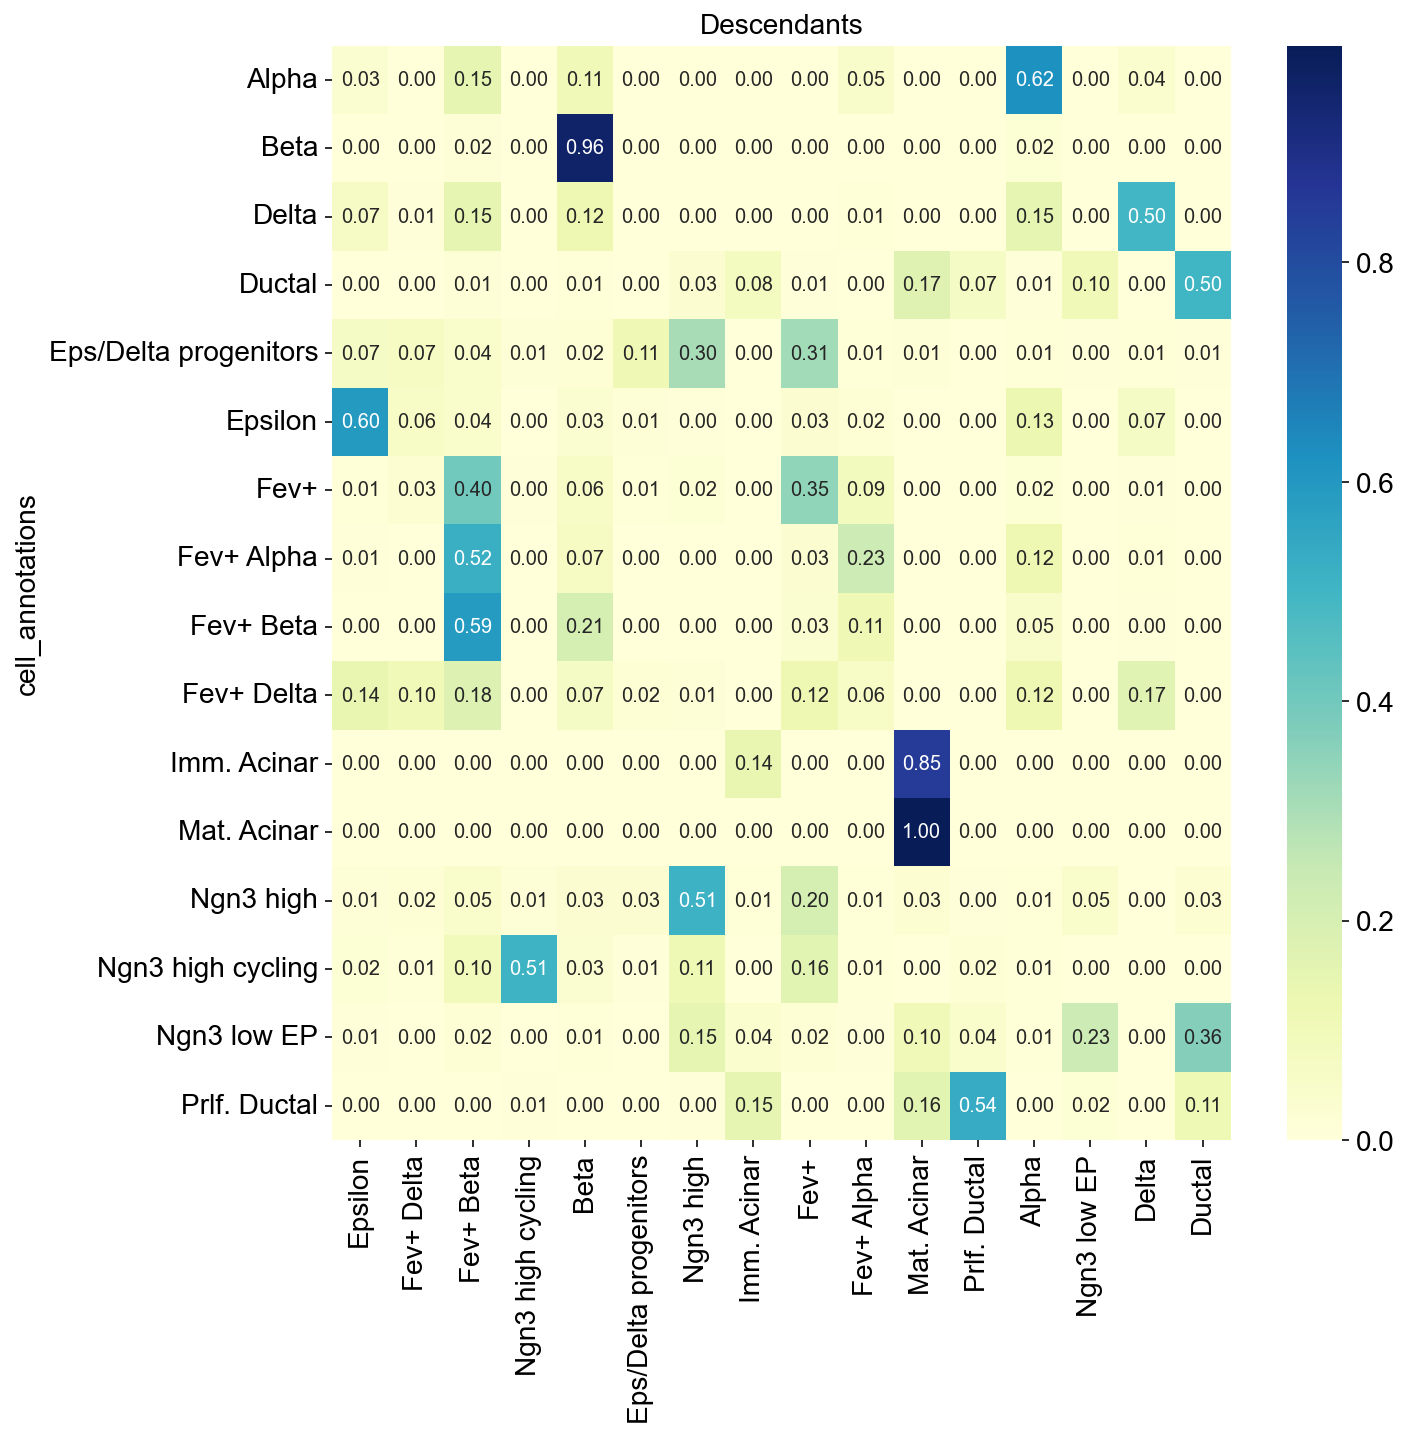

In [59]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(ct_desc, annot=True, cmap="YlGnBu", ax=ax, fmt=".2f", annot_kws={"fontsize": 10})
plt.title("Descendants")
plt.show()

In [16]:
ct_anc = tp0.cell_transition(early_cells="celltype", late_cells="celltype", start=0, end=1, forward=False)

/home/icb/dominik.klein/miniconda3/envs/moscot_env_05/lib/python3.9/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['neighbors_wnn']['connectivities'] that happens to be dimensioned at n_obs×n_obs (16978×16978).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/icb/dominik.klein/miniconda3/envs/moscot_env_05/lib/python3.9/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['neighbors_wnn']['connectivities'] that happens to be dimensioned at n_obs×n_obs (16978×16978).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(


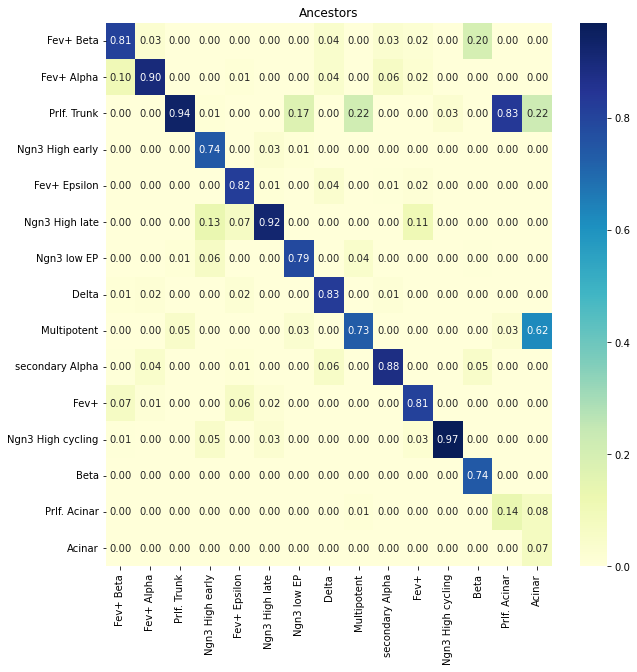

In [17]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(ct_anc, annot=True, cmap="YlGnBu", ax=ax, fmt=".2f", annot_kws={"fontsize": 10})
plt.title("Ancestors")
plt.show()

# scVI on GEX space

In [18]:
tp1 = TemporalProblem(adata)
tp1.score_genes_for_marginals(gene_set_proliferation="mouse", gene_set_apoptosis="mouse")
tp1 = tp1.prepare("time", joint_attr="X_scVI")

/mnt/home/icb/dominik.klein/git_repos/scanpy/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/mnt/home/icb/dominik.klein/git_repos/scanpy/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/icb/dominik.klein/miniconda3/envs/moscot_env_05/lib/python3.9/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['neighbors_wnn']['connectivities'] that happens to be dimensioned at n_obs×n_obs (16978×16978).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(


In [19]:
tp1 = tp1.solve(epsilon=5e-2, scale_cost="mean", tau_a=0.95, tau_b=0.99)

/mnt/home/icb/dominik.klein/git_repos/moscot/moscot/solvers/_base_solver.py:211: UserWarning: Solver did not converge
  warnings.warn("Solver did not converge")


In [20]:
ct_desc_scvi = tp1.cell_transition(early_cells="celltype", late_cells="celltype", start=0, end=1, forward=True)

/home/icb/dominik.klein/miniconda3/envs/moscot_env_05/lib/python3.9/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['neighbors_wnn']['connectivities'] that happens to be dimensioned at n_obs×n_obs (16978×16978).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/icb/dominik.klein/miniconda3/envs/moscot_env_05/lib/python3.9/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['neighbors_wnn']['connectivities'] that happens to be dimensioned at n_obs×n_obs (16978×16978).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(


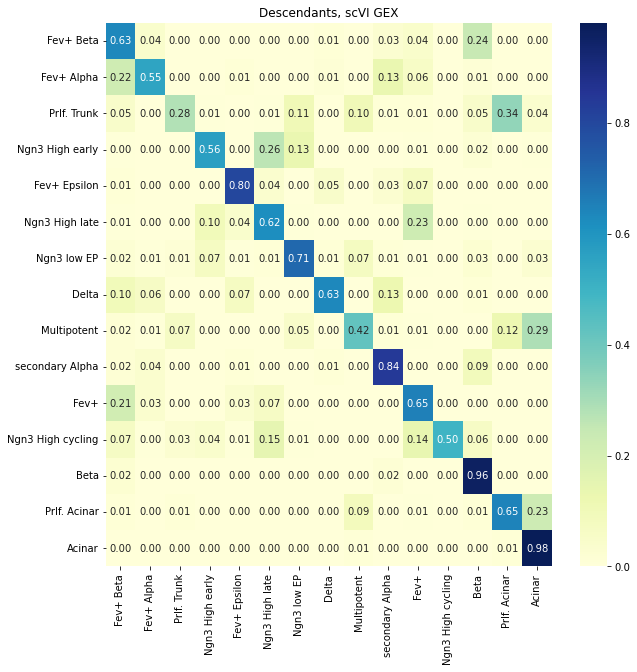

In [21]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(ct_desc_scvi, annot=True, cmap="YlGnBu", ax=ax, fmt=".2f", annot_kws={"fontsize": 10})
plt.title("Descendants, scVI GEX")
plt.show()

In [22]:
ct_anc_scvi = tp1.cell_transition(early_cells="celltype", late_cells="celltype", start=0, end=1, forward=False)

/home/icb/dominik.klein/miniconda3/envs/moscot_env_05/lib/python3.9/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['neighbors_wnn']['connectivities'] that happens to be dimensioned at n_obs×n_obs (16978×16978).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/icb/dominik.klein/miniconda3/envs/moscot_env_05/lib/python3.9/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['neighbors_wnn']['connectivities'] that happens to be dimensioned at n_obs×n_obs (16978×16978).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(


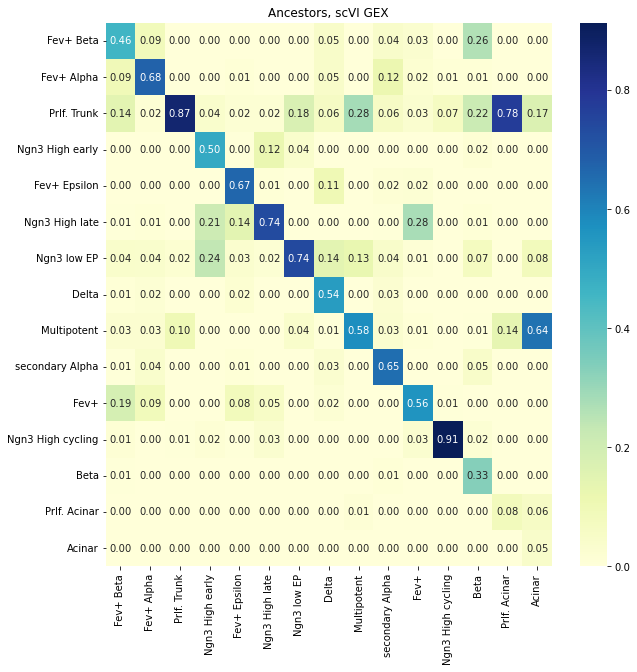

In [23]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(ct_anc_scvi, annot=True, cmap="YlGnBu", ax=ax, fmt=".2f", annot_kws={"fontsize": 10})
plt.title("Ancestors, scVI GEX")
plt.show()

# Compare PCA space with scVI space

Difference: PCA-GEX maps Trunk to Beta

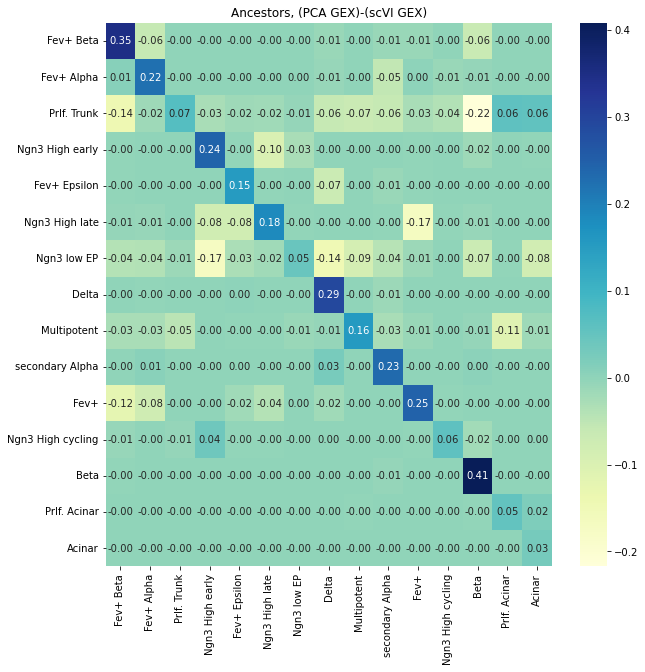

In [24]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(ct_anc - ct_anc_scvi, annot=True, cmap="YlGnBu", ax=ax, fmt=".2f", annot_kws={"fontsize": 10})
plt.title("Ancestors, (PCA GEX)-(scVI GEX)")
plt.show()

# PCA on GEX + PCA on ATAC space

In [92]:
from sklearn.metrics import pairwise_distances
import numpy as np

In [85]:
adata.obsm["GEX_pca"].std(), adata.obsm["ATAC_pca"].std()

(1.8982601, 15.407883)

In [90]:
gex_pca_tr = StandardScaler().fit_transform(adata.obsm["GEX_pca"])
atac_pca_tr = StandardScaler().fit_transform(adata.obsm["ATAC_pca"])

In [93]:
adata.obsm["joint_PCA"] = np.concatenate((gex_pca_tr, atac_pca_tr), axis=1)

In [79]:
C_gex = pairwise_distances(adata_gex[adata_gex.obs["time"]==0].obsm["X_pca"], adata_gex[adata_gex.obs["time"]==1].obsm["X_pca"], metric="sqeuclidean")
C_atac = pairwise_distances(adata_atac[adata_atac.obs["time"]==0].obsm["X_pca"], adata_atac[adata_atac.obs["time"]==1].obsm["X_pca"], metric="sqeuclidean")

In [119]:
tp2 = TemporalProblem(adata)
tp2 = tp2.prepare("time", joint_attr="joint_PCA")

In [120]:
tp2 = tp2.solve(epsilon=1e-3, scale_cost="mean", tau_a=1, tau_b=1)

In [121]:
ct_desc = tp2.cell_transition(early_cells="celltype", late_cells="celltype", start=0, end=1, forward=True)

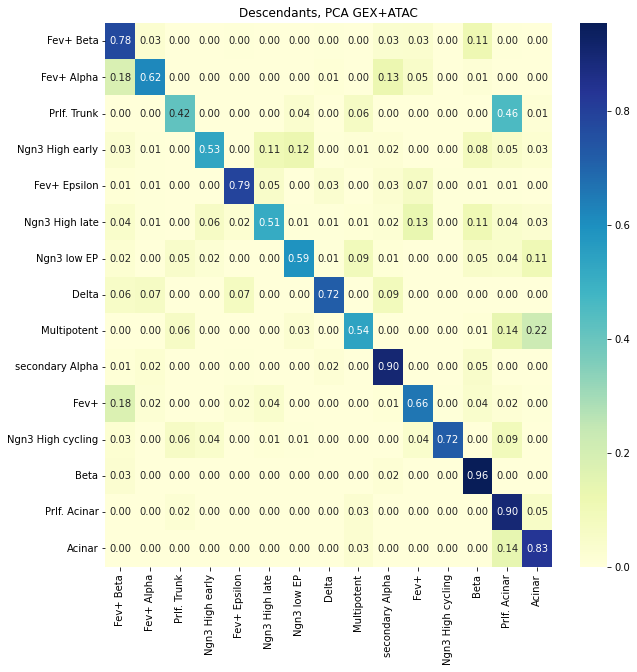

In [122]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(ct_desc, annot=True, cmap="YlGnBu", ax=ax, fmt=".2f", annot_kws={"fontsize": 10})
plt.title("Descendants, PCA GEX+ATAC")
plt.show()

In [103]:
ct_anc = tp2.cell_transition(early_cells="celltype", late_cells="celltype", start=0, end=1, forward=False)

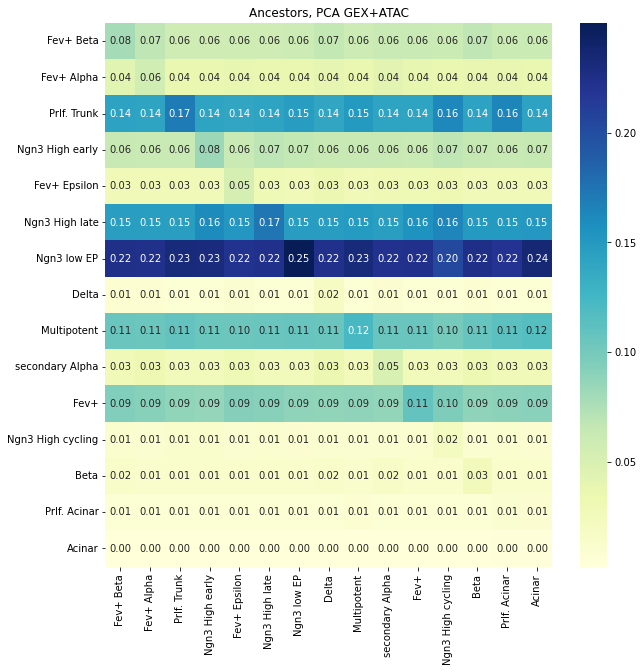

In [105]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(ct_anc, annot=True, cmap="YlGnBu", ax=ax, fmt=".2f", annot_kws={"fontsize": 10})
plt.title("Ancestors, PCA GEX+ATAC")
plt.show()

In [107]:
tp.cell_costs_source

,cell_cost_source
AAACAGCCAACAGCCT-1-0,-0.101696
AAACAGCCAACCCTCC-1-0,0.454478
AAACAGCCACCTGTAA-1-0,0.584158
AAACAGCCACTAAGCC-1-0,-0.144692
AAACAGCCAGGATAAC-1-0,-0.429829
...,...
TTTGTGTTCTTGTTCG-1-1,NaN
TTTGTTGGTATTGAGT-1-1,NaN
TTTGTTGGTCCTAAGA-1-1,NaN
TTTGTTGGTTAACAGT-1-1,NaN


In [108]:
sc.pl.umap(adata_gex, color=tp.cell_costs_source)

KeyError: "Could not find entry in `obsm` for 'umap'.\nAvailable keys are: ['ATAC_pca', 'ATAC_umap', 'GEX_pca', 'GEX_umap', 'X_pca']."

In [110]:
adata_gex

AnnData object with n_obs × n_vars = 16978 × 228321
    obs: 'n_counts', 'sample', 'int_id', 'reporter', 'log_cell_probs', 'cell_barcodes_du', 'cell_barcodes_cr', 'cell_barcodes', 'log_counts', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'total_counts_rank', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'log_nCount_ATAC', 'log_nFeature_ATAC', 'scrublet_scores', 'scrublet_doublets', 'scrublet_doublets_cat', 'dd_doublets', 'dd_scores', 'dd_log_p_values', 'dd_voting_average', 'dd_-log_p_values', 'dd_doublets_cat', 'pANN', 'DF_classifications_1', 'DF_classifications_2', 'pANN_SCT', 'DF_SCT_classifications_1', 'DF_SCT_classifications_2', 'df_doublets'